<a href="https://colab.research.google.com/github/EronDS/Neural-Networks/blob/main/CNNs/Images/Pulmonary_Infections_Identifier/Chest_ScanCLF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import pandas as pd
import keras 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
import os
from sklearn.model_selection import train_test_split
from keras.models import Sequential 
from keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout, Activation
from tensorflow.keras.utils import plot_model
from keras.optimizers import Adam,RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Data/Covid/Chest_xray_Corona_Metadata.csv')
df

Unnamed: 0  ... Label_1_Virus_category
0              0  ...                    NaN
1              1  ...                    NaN
2              2  ...                    NaN
3              3  ...                    NaN
4              4  ...                    NaN
...          ...  ...                    ...
5905        5928  ...                  Virus
5906        5929  ...                  Virus
5907        5930  ...                  Virus
5908        5931  ...                  Virus
5909        5932  ...                  Virus

[5910 rows x 6 columns]

In [3]:
df['Dataset_type'].value_counts()

TRAIN    5286
TEST      624
Name: Dataset_type, dtype: int64

In [4]:
train_df = df[: 5286]
test_df = df[5286:]

In [5]:
train_folder = '/content/drive/MyDrive/Data/Covid/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'
test_folder = '/content/drive/MyDrive/Data/Covid/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'


In [6]:
train_imgs = ['/content/drive/MyDrive/Data/Covid/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/{}'.format(i) for i in train_df.X_ray_image_name]
test_imgs = ['/content/drive/MyDrive/Data/Covid/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/{}'.format(i) for i in test_df.X_ray_image_name]

### **Example of Wild-Data present in Dataset** ####

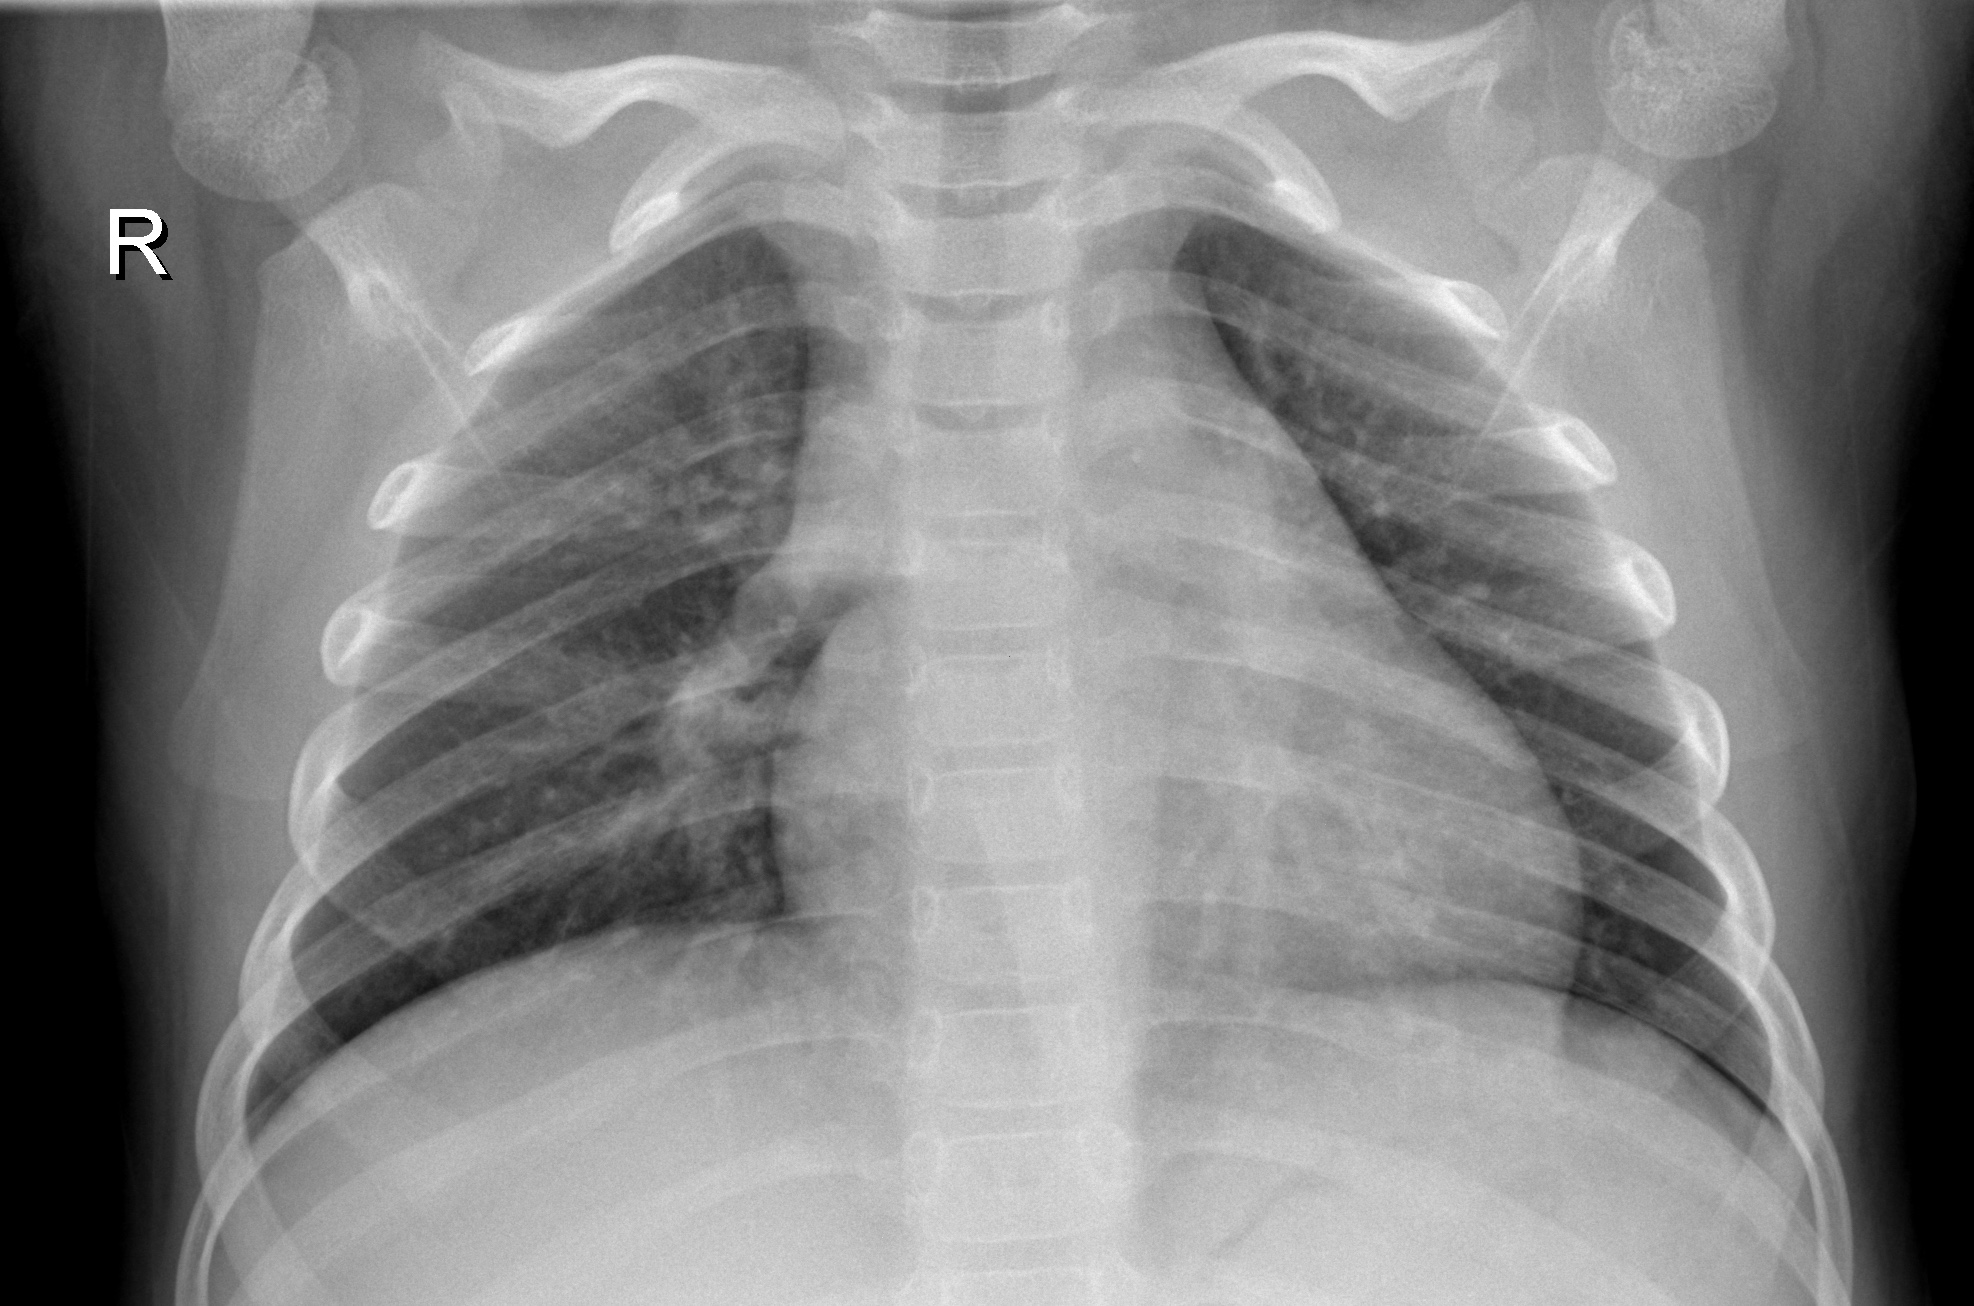

In [7]:
Image.open(train_imgs[1])

In [8]:

normal_idxs = [] 
pnemonia_idxs = []

idx = 0
for i in range(len(train_df.Label)):
  if train_df.Label[i] == 'Normal':
    normal_idxs.append(i)
  if train_df.Label[i] == 'Pnemonia':
    pnemonia_idxs.append(i)

### **Normal Chest X-Ray Examples** ###


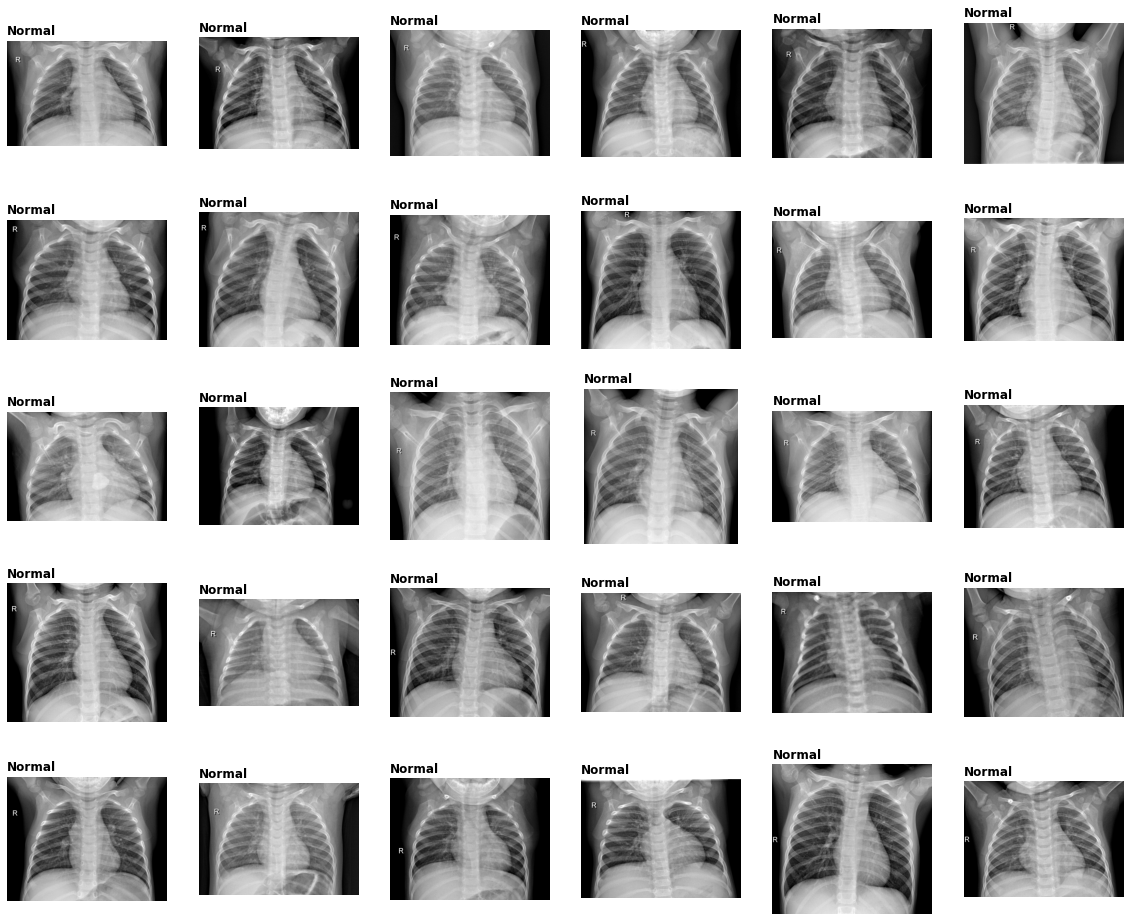

In [9]:
plt.figure(figsize=(20, 20))

for i in range(1 , 31):
    plt.subplot(6, 6, i )
    plt.imshow(Image.open(train_imgs[i]) , cmap = 'gray')
    plt.title(train_df.Label[i], loc = 'left' , weight = 'bold' , color = 'black')
    plt.axis('off')

plt.show()

### **Pneumonia Chest X-ray Examples** ###

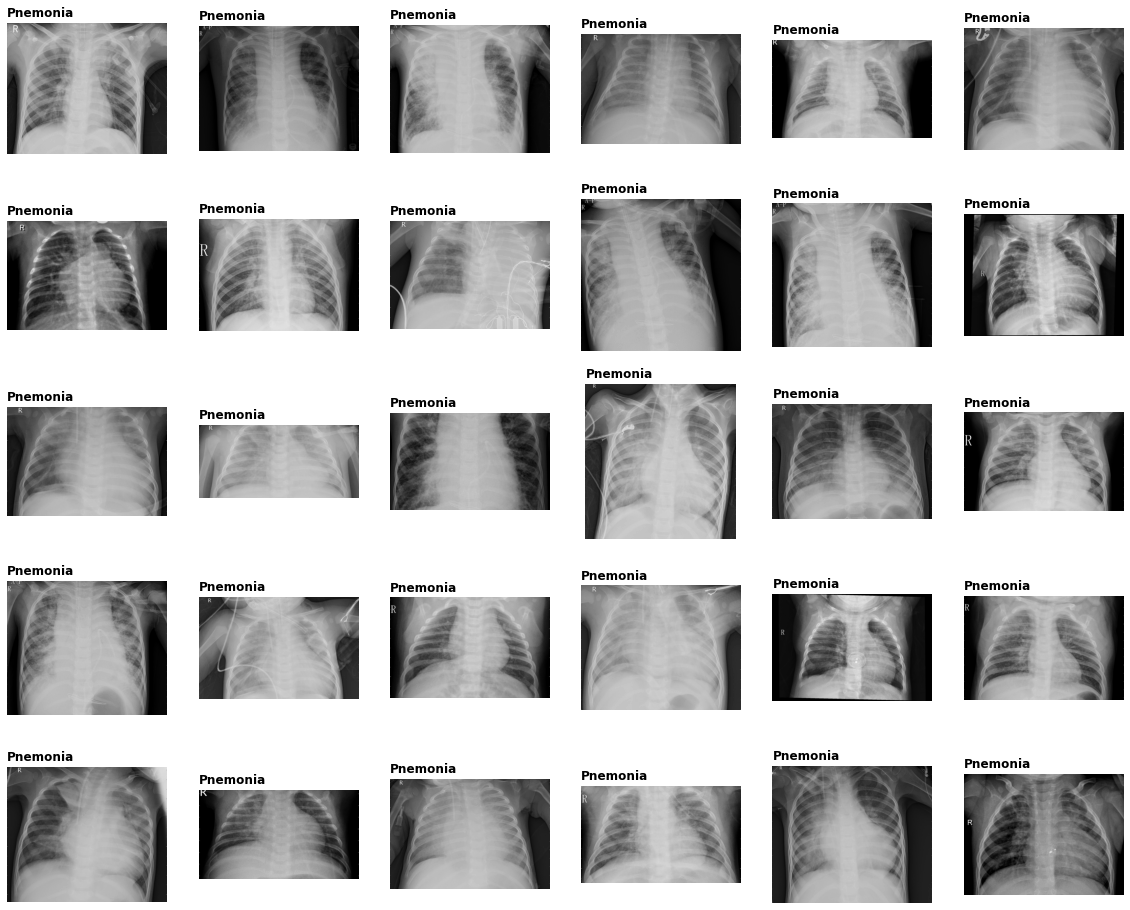

In [10]:
plt.figure(figsize=(20, 20))

for i in range(1 , 31):
    img = pnemonia_idxs[i]
    plt.subplot(6, 6, i )
    plt.imshow(Image.open(train_imgs[img]) , cmap = 'gray')
    plt.title(train_df.Label[img], loc = 'left' , weight = 'bold' , color = 'black')
    plt.axis('off')

plt.show()

### **Preprocessing** ###

In [11]:
train_df['filename'] = train_imgs
test_df['filename'] = test_imgs 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
x_train,x_val,y_train,y_val = train_test_split(train_df.X_ray_image_name, train_df.Label)

In [13]:
train_df = pd.DataFrame({'filename':x_train,'label': y_train})
val_df = pd.DataFrame({'filename': x_val , 'label': y_val})

In [14]:
train_df.label.value_counts()

Pnemonia    2962
Normal      1002
Name: label, dtype: int64

In [15]:
val_df.label.value_counts()

Pnemonia    982
Normal      340
Name: label, dtype: int64

In [16]:
datagen = ImageDataGenerator(rescale = 1./255)

train_val_dir = '/content/drive/MyDrive/Data/Covid/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/'


train_data = datagen.flow_from_dataframe(train_df,train_val_dir,
                                         x_col = 'filename' , y_col = 'label',
                                         target_size = (60,60) , color_mode = 'grayscale' ,class_mode = 'binary')

val_data = datagen.flow_from_dataframe(val_df, train_val_dir,
                                       x_col = 'filename' , y_col = 'label' ,
                                       target_size = (60,60) , color_mode = 'grayscale' , class_mode = 'binary')

Found 3964 validated image filenames belonging to 2 classes.
Found 1322 validated image filenames belonging to 2 classes.


### **Creating Baseline Model** ###

In [17]:
model1 = Sequential()
model1.add(Conv2D(64,2, padding = 'same', 
                 input_shape = (60,60,1)))
model1.add(Activation('relu'))
model1.add(Conv2D(32, 2 , strides = 2, padding  = 'same'))
model1.add(Activation('relu'))
model1.add(MaxPool2D(pool_size = (2,2)))
model1.add(Conv2D(32, 2 , strides = 2, padding  = 'same'))
model1.add(Activation('relu'))
model1.add(MaxPool2D(pool_size = (2,2)))
model1.add(Dropout(.25))



model1.add(Flatten())
model1.add(Dense(64))
model1.add(Activation('relu'))
model1.add(Dropout(.33))
model1.add(Dense(1, activation= 'sigmoid'))

In [18]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 64)        320       
_________________________________________________________________
activation (Activation)      (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        8224      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          4128      
_________________________________________________________________
activation_2 (Activation)    (None, 8, 8, 32)          0

In [19]:
model1.compile(optimizer = RMSprop(), loss = 'binary_crossentropy' ,metrics = ['acc'])

In [20]:
train_steps = train_data.n // train_data.batch_size
val_steps = val_data.n // val_data.batch_size 

history1 = model1.fit_generator(train_data,train_steps,epochs = 5,
                                validation_data = val_data,
                                validation_steps = val_steps)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
123/123 [==============================] - 71s 415ms/step - loss: 0.5649 - acc: 0.7497 - val_loss: 0.4011 - val_acc: 0.8285
Epoch 2/5
123/123 [==============================] - 50s 409ms/step - loss: 0.2839 - acc: 0.8867 - val_loss: 0.1743 - val_acc: 0.9352
Epoch 3/5
123/123 [==============================] - 51s 412ms/step - loss: 0.2184 - acc: 0.9147 - val_loss: 0.1616 - val_acc: 0.9390
Epoch 4/5
123/123 [==============================] - 51s 414ms/step - loss: 0.1932 - acc: 0.9205 - val_loss: 0.1377 - val_acc: 0.9558
Epoch 5/5
123/123 [==============================] - 50s 410ms/step - loss: 0.1765 - acc: 0.9341 - val_loss: 0.1199 - val_acc: 0.9634


In [21]:
test_dir = '/content/drive/MyDrive/Data/Covid/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/'

test_data = datagen.flow_from_dataframe(test_df, test_dir,
                                       x_col = 'filename' , y_col = 'Label' ,
                                       target_size = (60,60) , color_mode = 'grayscale' , class_mode = 'binary')

Found 624 validated image filenames belonging to 2 classes.


Text(0.0, 1.0, 'Accuracy & Validation Accuracy in Baseline Model')

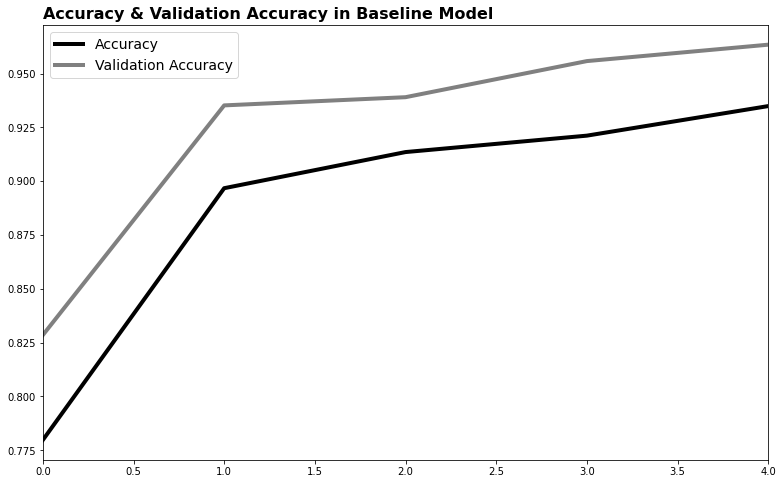

In [47]:
acc = history1.history['acc']
val_acc = history1.history['val_acc']



plt.figure(figsize = (13,8))
plt.plot(range(len(acc)) , acc , color = 'black' , label = 'Accuracy' , linewidth = 4)
plt.plot(val_acc , color = 'grey', label = 'Validation Accuracy', linewidth = 4)
plt.xlim(0 , len(acc) - 1)
plt.legend(fontsize = 14)
plt.title('Accuracy & Validation Accuracy in Baseline Model' , loc = 'left',
          weight = 'bold', fontsize = 16)


In [23]:
model1.evaluate(test_data)

20/20 [==============================] - 5s 249ms/step - loss: 0.6823 - acc: 0.7756


[0.6822845935821533, 0.7756410241127014]

In [24]:
test_data.class_indices

{'Normal': 0, 'Pnemonia': 1}

In [25]:
preds = model1.predict_classes(test_data)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


### **Prediction from our Model with 80% of Accuracy** ###

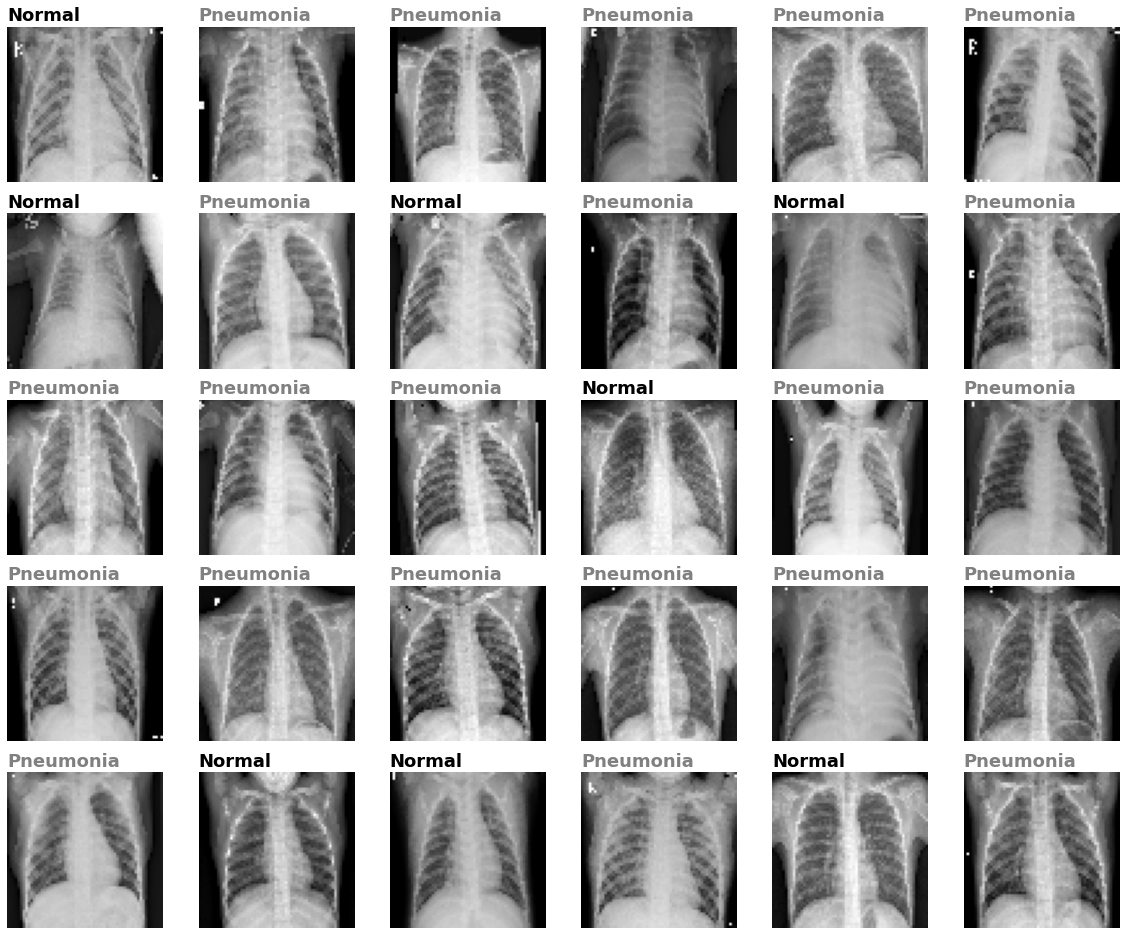

In [26]:
plt.figure(figsize=(20, 20))

for i in range(1 , 31):
    plt.subplot(6, 6, i )
    plt.imshow(test_data[0][0][i].reshape(60,60), cmap = 'gray')
    if preds[i] == 0:
      plt.title('Normal' , color = 'black' , loc = 'left', weight = 'bold' , fontsize = 18)
    if preds[i] == 1:
      plt.title('Pneumonia' , color = 'grey' , loc = 'left' , weight = 'bold' , fontsize = 18)

    plt.axis('off')

plt.show()

In [27]:
#model1.save('model1.h5')

### **Improving our Model** ###

In [28]:
ReducingLearningRate = ReduceLROnPlateau(monitor = 'loss',
                                         verbose = 1,
                                         patience = 20)
EarlyStop = EarlyStopping(monitor ='val_acc' , patience = 10)

###Reducing Layers. Trying a more Parsimonious Structure to Avoid Overfitting ###

In [29]:
model2= Sequential()
model2.add(Conv2D(64,2, padding = 'same', 
                 input_shape = (60,60,1)))
model2.add(Activation('relu'))
model2.add(Conv2D(32, 2 , strides = 2, padding  = 'same'))
model2.add(Activation('relu'))
model2.add(MaxPool2D(pool_size = (2,2)))
model2.add(Dropout(.25))



model2.add(Flatten())
model2.add(Dense(64))
model2.add(Activation('relu'))
model2.add(Dropout(.33))
model2.add(Dense(1, activation= 'sigmoid'))

In [30]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 60, 60, 64)        320       
_________________________________________________________________
activation_4 (Activation)    (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 32)        8224      
_________________________________________________________________
activation_5 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7200)             

In [31]:
train_df = df[: 5286]

In [32]:
x_train,x_val,y_train,y_val = train_test_split(train_df.X_ray_image_name, train_df.Label, test_size =.5)

In [33]:
train_df = pd.DataFrame({'filename':x_train,'label': y_train})
val_df = pd.DataFrame({'filename': x_val , 'label': y_val})

In [34]:
model2.compile(Adam(), loss = 'binary_crossentropy' , metrics = ['acc'])

In [35]:
datagen = ImageDataGenerator(rescale = 1./255)

train_val_dir = '/content/drive/MyDrive/Data/Covid/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/'


train_data = datagen.flow_from_dataframe(train_df,train_val_dir,
                                         x_col = 'filename' , y_col = 'label',
                                         target_size = (60,60) , color_mode = 'grayscale' ,class_mode = 'binary')

val_data = datagen.flow_from_dataframe(val_df, train_val_dir,
                                       x_col = 'filename' , y_col = 'label' ,
                                       target_size = (60,60) , color_mode = 'grayscale' , class_mode = 'binary')

Found 2643 validated image filenames belonging to 2 classes.
Found 2643 validated image filenames belonging to 2 classes.


In [36]:
train_steps = train_data.n // train_data.batch_size
val_steps = val_data.n // val_data.batch_size 

history2 = model2.fit_generator(train_data,train_steps,epochs = 15,
                                validation_data = val_data,
                                validation_steps = val_steps,
                                callbacks =[ReducingLearningRate, EarlyStop])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
82/82 [==============================] - 51s 616ms/step - loss: 0.5214 - acc: 0.7593 - val_loss: 0.2249 - val_acc: 0.9215
Epoch 2/15
82/82 [==============================] - 50s 610ms/step - loss: 0.2427 - acc: 0.8978 - val_loss: 0.1435 - val_acc: 0.9539
Epoch 3/15
82/82 [==============================] - 50s 613ms/step - loss: 0.1529 - acc: 0.9422 - val_loss: 0.1181 - val_acc: 0.9581
Epoch 4/15
82/82 [==============================] - 50s 613ms/step - loss: 0.1469 - acc: 0.9446 - val_loss: 0.1210 - val_acc: 0.9592
Epoch 5/15
82/82 [==============================] - 50s 614ms/step - loss: 0.1223 - acc: 0.9516 - val_loss: 0.1102 - val_acc: 0.9627
Epoch 6/15
82/82 [==============================] - 50s 611ms/step - loss: 0.1161 - acc: 0.9625 - val_loss: 0.1116 - val_acc: 0.9577
Epoch 7/15
82/82 [==============================] - 50s 611ms/step - loss: 0.1108 - acc: 0.9626 - val_loss: 0.1404 - val_acc: 0.9566
Epoch 8/15
82/82 [==============================] - 49s 606ms/step - 

Text(0.0, 1.0, 'Accuracy & Validation Accuracy')

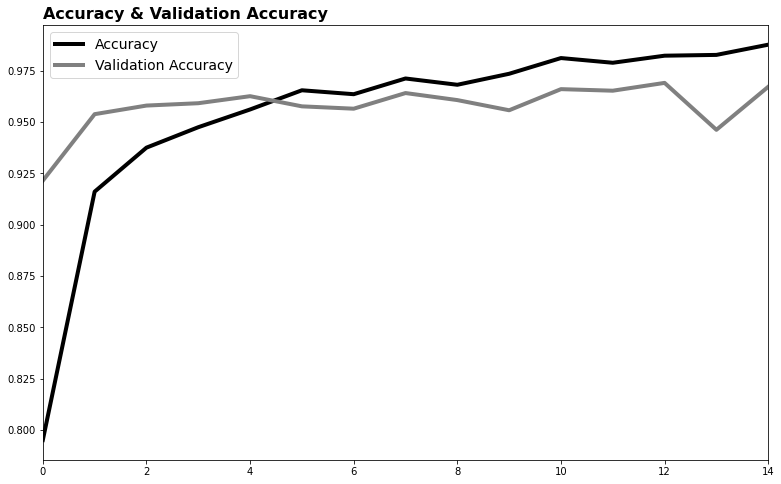

In [37]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']

plt.figure(figsize = (13,8))
plt.plot(range(len(acc)) , acc , color = 'black' , label = 'Accuracy' , linewidth = 4)
plt.plot(val_acc , color = 'grey', label = 'Validation Accuracy', linewidth = 4)
plt.xlim(0 , len(acc) - 1)
plt.legend(fontsize = 14)
plt.title('Accuracy & Validation Accuracy' , loc = 'left',
          weight = 'bold', fontsize = 16)

In [38]:
model2.save('model2.h5')

In [41]:
model2.evaluate(test_data)[1]

20/20 [==============================] - 5s 252ms/step - loss: 2.0396 - acc: 0.7420


0.7419871687889099

In [44]:
preds = model2.predict_classes(test_data)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [48]:
test_data.class_indices

{'Normal': 0, 'Pnemonia': 1}

In [53]:
y = test_data.labels

In [73]:
len(y)

624

### **Predição do Modelo para Dados de Validação** ###

*Cores das imagens foram alteradas para melhor visualização do leitor

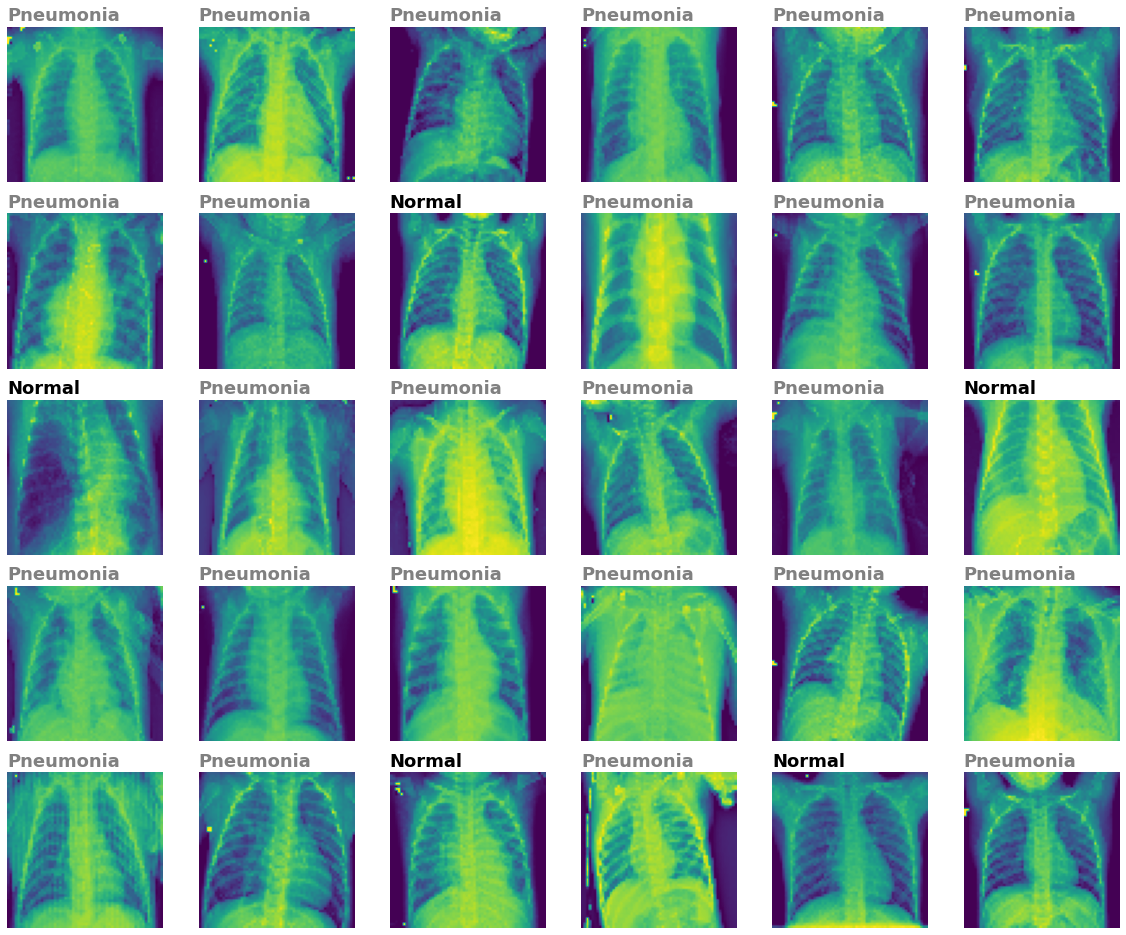

In [78]:
plt.figure(figsize=(20, 20))



for i in range(1 , 31):
    plt.subplot(6, 6, i )
    plt.imshow(val_data[0][0][i].reshape(60,60))
    if preds[i] == 0:
      plt.title('Normal' , color = 'black' , loc = 'left', weight = 'bold' , fontsize = 18)
    if preds[i] == 1:
      plt.title('Pneumonia' , color = 'grey' , loc = 'left' , weight = 'bold' , fontsize = 18)

    plt.axis('off')

plt.show()